# Predicting Start-up Funding Amounts

**Goal:**  
In this notebook, we build a machine learning pipeline to predict how much funding a start-up receives (`funding_total_usd`). The assignment requires us to:

- Use 5-fold cross-validation
- Evaluate on a hold-out test set
- Apply feature engineering and possibly external data
- Test different models and tune hyperparameters
- Explain modelling steps clearly and present results

We follow these steps:
1. Load and preprocess the start-up dataset
2. Merge external GDP data
3. Create and transform relevant features
4. Build preprocessing and modelling pipeline
5. Use GridSearchCV for model tuning (where applicable)
6. Evaluate model performance using R² and RMSE
7. Compare multiple regression models


Model Performance Summary
                   Train R²  Test R²  RMSE (log)  RMSE ($)
XGBoost               0.604    0.535       1.561     3.764
Linear Regression     0.527    0.496       1.627     4.087
Decision Tree         0.471    0.471       1.665     4.287
AdaBoost              0.452    0.458       1.685     4.395


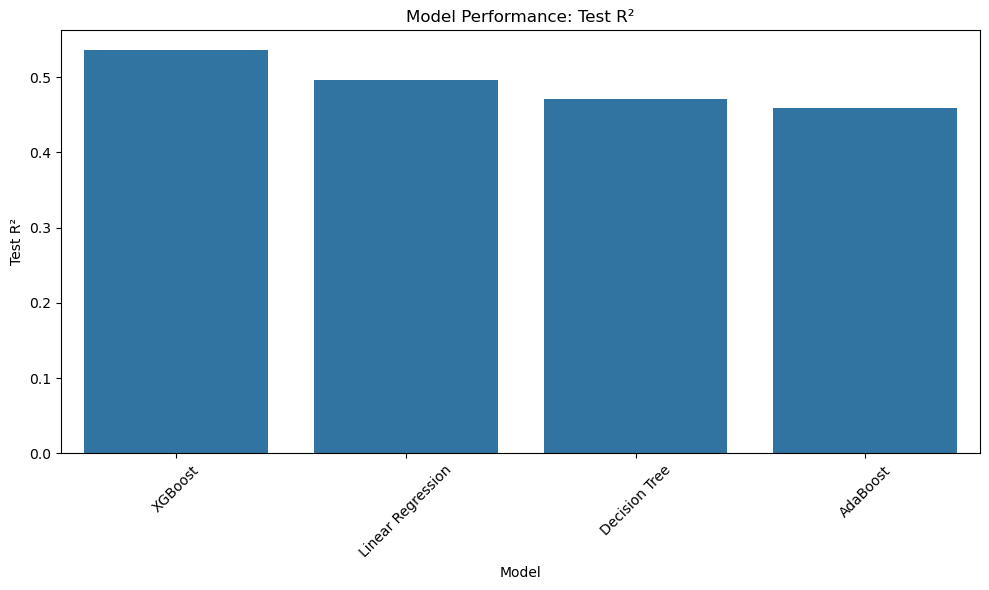

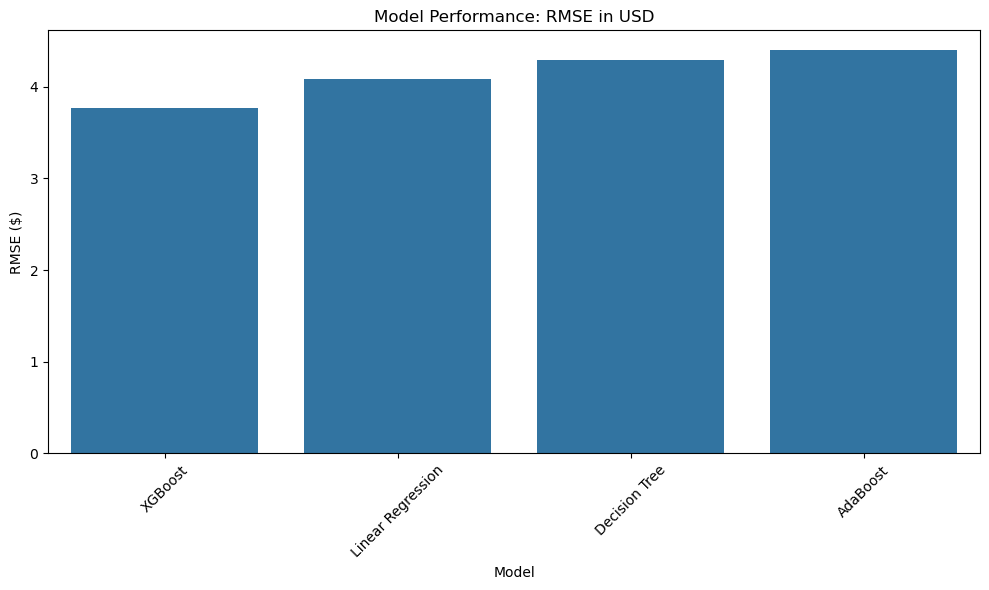

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor
from xgboost import XGBRegressor
from sklearn.metrics import r2_score, root_mean_squared_error 

#load and prepare data 
org = pd.read_csv("organisations.csv")
org['funding_total_usd'] = pd.to_numeric(org['funding_total_usd'], errors='coerce')
org = org[org['funding_total_usd'] > 0]

org['founded_at'] = pd.to_datetime(org['founded_at'], errors='coerce')
org['first_funding_at'] = pd.to_datetime(org['first_funding_at'], errors='coerce')
org['last_funding_at'] = pd.to_datetime(org['last_funding_at'], errors='coerce')
org = org.dropna(subset=['founded_at', 'funding_rounds'])

org['founded_year'] = org['founded_at'].dt.year
org['time_to_first_funding'] = (org['first_funding_at'] - org['founded_at']).dt.days
org['time_to_last_funding'] = (org['last_funding_at'] - org['founded_at']).dt.days
org['age_at_last_funding'] = org['last_funding_at'].dt.year - org['founded_year']
org['funding_duration'] = org['time_to_last_funding'] - org['time_to_first_funding']
org['category_count'] = org['category_list'].apply(lambda x: len(str(x).split('|')) if pd.notnull(x) else 0)

log_features = ['funding_rounds', 'time_to_first_funding', 'time_to_last_funding',
                'age_at_last_funding', 'category_count', 'funding_duration']
for col in log_features:
    org[col] = org[col].clip(lower=0).fillna(0)
    org[col] = np.log1p(org[col])

# Load and merge GDP data
gdp = pd.read_csv("World_ Gross domestic product.csv")
gdp = gdp.rename(columns={'Variable observation date': 'year', 'Variable observation value': 'gdp_value'})
gdp['gdp_trillion'] = gdp['gdp_value'] / 1e12
gdp['year'] = gdp['year'].astype(int)

org = org.merge(gdp[['year', 'gdp_trillion']], left_on='founded_year', right_on='year', how='left')

#drop unused columns
org = org.drop(columns=['permalink', 'homepage_url', 'region', 'city', 'founded_at',
                        'first_funding_at', 'last_funding_at', 'year', 'name', 'category_list'])

# Define target and features 
y = np.log1p(org['funding_total_usd'])
X = org.drop(columns=['funding_total_usd'])

#Train/test split 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Preprocessing pipeline 
categorical_cols = ['market', 'status', 'country_code', 'state_code']
numeric_cols = [col for col in X.columns if col not in categorical_cols]
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numeric_cols),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
])

# Define models and hyperparammeters
models = {
    "Linear Regression": {
        "model": LinearRegression()
    },
    "Decision Tree": {
        "model": DecisionTreeRegressor(random_state=42),
        "params": {
            "max_depth": [3, 5, 10, 20],
            "min_samples_split": [2, 5, 10],
            "min_samples_leaf": [1, 2, 4]
        }
    },
    "AdaBoost": {
        "model": AdaBoostRegressor(random_state=42),
        "params": {
            "n_estimators": [50, 100, 200],
            "learning_rate": [0.01, 0.05, 0.1, 0.5],
            "loss": ["linear", "square"]
        }
    },
    "XGBoost": {
        "model": XGBRegressor(n_jobs=8, random_state=42, verbosity=0),
        "params": {
            "n_estimators": [50, 100, 200],
            "max_depth": [3, 5, 7],
            "learning_rate": [0.01, 0.05, 0.1],
            "subsample": [0.8, 1.0],
            "colsample_bytree": [0.8, 1.0]
        }
    }
}

#train and evaluate models
results = {}

for name, cfg in models.items():
    pipe = Pipeline([
        ('preprocessor', preprocessor),
        ('model', cfg['model'])
    ])
    
    if 'params' in cfg:
        grid = GridSearchCV(pipe,
                            param_grid={f"model__{k}": v for k, v in cfg['params'].items()},
                            cv=KFold(n_splits=5, shuffle=True, random_state=42),
                            scoring='r2',
                            n_jobs=4)
        grid.fit(X_train, y_train)
        best_model = grid.best_estimator_
    else:
        pipe.fit(X_train, y_train)
        best_model = pipe

    y_train_pred = best_model.predict(X_train)
    y_test_pred = best_model.predict(X_test)

    rmse_log = root_mean_squared_error(y_test, y_test_pred)  
    rmse_dollar = np.expm1(rmse_log)

    results[name] = {
        "Train R²": r2_score(y_train, y_train_pred),
        "Test R²": r2_score(y_test, y_test_pred),
        "RMSE (log)": rmse_log,
        "RMSE ($)": rmse_dollar
    }

#display results
results_df = pd.DataFrame(results).T
results_df = results_df[['Train R²', 'Test R²', 'RMSE (log)', 'RMSE ($)']]
results_df = results_df.sort_values(by='Test R²', ascending=False)

print("Model Performance Summary")
print(results_df.round(3))

# Visualize results 
plt.figure(figsize=(10, 6))
sns.barplot(data=results_df.reset_index(), x='index', y='Test R²')
plt.title('Model Performance: Test R²')
plt.xlabel('Model')
plt.ylabel('Test R²')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
sns.barplot(data=results_df.reset_index(), x='index', y='RMSE ($)')
plt.title('Model Performance: RMSE in USD')
plt.xlabel('Model')
plt.ylabel('RMSE ($)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


### Performance Summary

| Model              | Train R² | Test R² | RMSE (log) | RMSE ($) |
|-------------------|----------|---------|------------|----------|
| **XGBoost**        | 0.604    | 0.535   | 1.561      | 3.764M   |
| Linear Regression  | 0.527    | 0.496   | 1.627      | 4.087M   |
| Decision Tree      | 0.471    | 0.471   | 1.665      | 4.287M   |
| AdaBoost           | 0.452    | 0.458   | 1.685      | 4.395M   |

**Conclusion:**
- XGBoost performed best with the highest R² and lowest RMSE.
- Linear Regression performed surprisingly well considering its simplicity.
- Ensemble methods (XGBoost and AdaBoost) help, especially when tuned.
- All models generalize reasonably, showing no strong signs of overfitting.
